In [1]:
import random
import os
import shutil
import glob
import gc
import sys
import h5py
import time
import datetime
import pickle
import librosa
import warnings
import matplotlib.pyplot as plt

from graphs import draw
import graphs

import numpy as np
from numpy import array
import pandas as pd
from pandas.plotting import parallel_coordinates
from pydub import AudioSegment

#imported for testing
import wave
import contextlib

# for outputing file
from scipy.cluster.vq import vq, kmeans, whiten
import scipy.stats.stats as st

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight

import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Add, Dropout, Input, Activation
from keras.layers import TimeDistributed, Bidirectional, LSTM, LeakyReLU
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers, regularizers
from keras.utils import np_utils, to_categorical

from IPython.display import clear_output

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
# print(len(backend.tensorflow_backend._get_available_gpus()) > 0)

sample_rate=44100
hop_length = 441  # frame size= 2*hop
segment_length=int(sample_rate*0.2)  #0.2
segment_pad=int(sample_rate*0.02)     #0.02
overlappiong=int(sample_rate*0.1)   #0.1

NumofFeaturetoUse = 272 # this will re-assigned for different classifiers
frame_number = 48

sys.path.insert(1, '..//components//')
import load_feat_directories

# input new indices file here
# indices_filename = 'D://indices_filename.npy'
# indices=np.load(indices_filename)

Using TensorFlow backend.


In [2]:
def avail_modules(directory, prefix):
    module_names = []
    for item in os.listdir(directory):
        if prefix in item:
            module_names.append(directory + item)
            i = module_names.index(directory + item)
            print(str(i) + 'th module')
            print(directory + item)
    return module_names

In [3]:
def comprise_vector(path, dist, reverb, noise):
    vec_to_return = []
    for fname in os.listdir(path):
        components = fname.split('_')
        '''
        if dist == 0 and 'deamp' in components: continue
        if reverb == 0 and 'WetDry' in components: continue
        if noise == 0 and 'noise' in components: continue
        '''
        current_vec = np.load(path + fname)
        vec_to_return.append(current_vec)
        
    vec_to_return = np.array(vec_to_return)
    return vec_to_return

In [4]:
def comprise_label(feature_vector, label):
    label_vec_to_ret = []
    length = len(list(feature_vector))
    for index in range(0, length):
        current_label = [label]
        label_vec_to_ret.append(current_label)
    label_vec_to_ret = np.array(label_vec_to_ret)

    return label_vec_to_ret

def float_compatible(input_np):

    x = np.where(input_np >= np.finfo(np.float32).max)
    for index in range(0, len(x[0])):
        x_position = x[0][index]
        y_position = x[1][index]
        input_np[x_position, y_position] = 0.0
    input_np = np.nan_to_num(input_np)

    return input_np

def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# allnoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
# homenoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
all_noised_npy = load_feat_directories.allnoised_npy
all_noised_npy_test = load_feat_directories.allnoised_npy_test
home_noised_npy = load_feat_directories.homenoised_npy
home_noised_npy_test = load_feat_directories.homenoised_npy_test

for index in range(0, 5):
    if not os.path.exists(all_noised_npy_test[index]):
        print(all_noised_npy_test[index] + ' does not exist. Breaking the loop... ')
    if not os.path.exists(home_noised_npy[index]):
        print(home_noised_npy_test[index] + 'does not exist. Breaking the loop... ')

In [6]:
emotions = [0, 1, 2, 3]
home_or_all = 'home'
dist = 0
reverb = 0
noise = 0

for index in emotions:
    if home_or_all == 'home':
        path = home_noised_npy_test[index]
    else:
        path = all_noised_npy_test[index]
        
    if index == 0:
        val_h_feat = comprise_vector(path, dist, reverb, noise)
        val_h_label = comprise_label(val_h_feat, index)
    elif index == 1:
        val_a_feat = comprise_vector(path, dist, reverb, noise)
        val_a_label = comprise_label(val_a_feat, index)
    elif index == 2:
        val_n_feat = comprise_vector(path, dist, reverb, noise)
        val_n_label = comprise_label(val_n_feat, index)
    elif index == 3:
        val_s_feat = comprise_vector(path, dist, reverb, noise)
        val_s_label = comprise_label(val_s_feat, index)
    else:
        val_o_feat = comprise_vector(path, dist, reverb, noise)
        val_o_label = comprise_label(val_o_feat, index)     


# Top (Binary)

In [7]:
def top_eval_all(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            
            one_sample = np.load(emotionFolder + emotionfile)
            one_sample = np.array([one_sample])
            zero_score, one_score = model.predict(one_sample)[0]
            zero_scores.append(zero_score)
            one_scores.append(one_score)

            if val == 0:
                if zero_score > one_score: correct += 1
                else: incorrect += 1
            else:
                if one_score > zero_score: correct += 1
                else: incorrect += 1

            total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [8]:
def top_eval_original(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise 
            
            if original:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [9]:
def top_eval_deamplified_noised(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                components = emotionfile.split('_')
                deamplified_amount_position = components.index('deamp') + 1
                deamplified = float(components[deamplified_amount_position])
                deamplified_dbs.append(deamplified)
                
                zero_score, one_score = model.predict(one_sample)[0]
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [10]:
def top_eval_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if r:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                
                components = emotionfile.split('_')
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [11]:
def top_eval_deamplified_noised_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        if 'Angry' in emotionFolder: val = 0
        if 'Neutral' in emotionFolder: val = 1
        if 'Sad' in emotionFolder: val = 1

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_r_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score = model.predict(one_sample)[0]
                
                components = emotionfile.split('_')
                
                deamplified_position = components.index('deamp') + 1
                deamplified_dbs.append(float(components[deamplified_position]))
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == 0:
                    if zero_score > one_score: correct += 1
                    else: incorrect += 1
                else:
                    if one_score > zero_score: correct += 1
                    else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors,
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [12]:
def predict_cnn(model):
    y_pred = []
    y_true = []

    for item in list(Label_val):
            if item[0] > item[1]:
                y_true.append(0)
            elif item[0] < item[1]:
                y_true.append(1)
            else:
                y_true.append(0)

    for item in list(model.predict(featureSet_val)):
            if item[0] > item[1]:
                y_pred.append(0)
            elif item[0] < item[1]:
                y_pred.append(1)
            else:
                y_pred.append(0)

    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('f1 score: ' + str(f1_score(y_true, y_pred)))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print('true positive ' + str(tp))
    print('false positive ' + str(fp))
    print('false negative ' + str(fn))
    print('true negative ' + str(tn))

In [13]:
# Load testing npy files
featureSet_val = float_compatible(np.vstack((val_h_feat, val_a_feat, val_n_feat, val_s_feat)))
Label_val = np.vstack((val_h_label, val_a_label, val_n_label, val_s_label))
Label_val[Label_val == 0] = 0
Label_val[Label_val == 1] = 0
Label_val[Label_val == 2] = 1
Label_val[Label_val == 3] = 1
Label_val = to_categorical(Label_val)
print('evaluation data: ' + str(featureSet_val.shape))
print('evaluation label: ' + str(Label_val.shape))

evaluation data: (7551, 48, 272)
evaluation label: (7551, 2)


In [14]:
directory = '//Volumes//ASH//modules//'
module_prefix = 'Top_'
modules = avail_modules(directory, module_prefix)

0th module
//Volumes//ASH//modules//Checkpoint_home_Top_neurons_home_2048_filters_1024_dropout_0.2_epoch_1000_dense_6.hdf5


In [15]:
title = modules[0]
model = keras.models.load_model(title)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Specify the directories that contain the files of emotion

In [16]:
emotionFolders = [home_noised_npy_test[0], home_noised_npy_test[1], \
                  home_noised_npy_test[2], home_noised_npy_test[3]]

## Only evaluate unmodified wav files

### evaluate the set of Happy validation

In [ ]:
dictionary_original_h = top_eval_original([emotionFolders[0]])
one_scores_original_h = dictionary_original_h.get('one_scores')
zero_scores_original_h = dictionary_original_h.get('zero_scores')

### evaluate the set of Angry validation

In [ ]:
dictionary_original_a = top_eval_original([emotionFolders[1]])
one_scores_original_a = dictionary_original_a.get('one_scores')
zero_scores_original_a = dictionary_original_a.get('zero_scores')

### evaluate the set of Neutral validation

In [ ]:
dictionary_original_n = top_eval_original([emotionFolders[2]])
one_scores_original_n = dictionary_original_n.get('one_scores')
zero_scores_original_n = dictionary_original_n.get('zero_scores')

### evaluate the set of Sad validation

In [ ]:
dictionary_original_s = top_eval_original([emotionFolders[3]])
one_scores_original_s = dictionary_original_s.get('one_scores')
zero_scores_original_s = dictionary_original_s.get('zero_scores')

### draw the plot (evaluation on only unmodified, original wav files)

In [ ]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only unmodified, original wav files'
results = {
    'Happy': [dictionary_original_h.get('error_rate'), dictionary_original_h.get('accuracy')],
    'Angry': [dictionary_original_a.get('error_rate'), dictionary_original_a.get('accuracy')],
    'Neutral': [dictionary_original_n.get('error_rate'), dictionary_original_n.get('accuracy')],
    'Sad': [dictionary_original_s.get('error_rate'), dictionary_original_s.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate reverberated wav files

### evaluate the set of Happy validation

In [ ]:
dictionary_reverbed_h = top_eval_reverbed([emotionFolders[0]])

one_scores_reverbed_h = dictionary_reverbed_h.get('one_scores')
zero_scores_reverbed_h = dictionary_reverbed_h.get('zero_scores')

wetdrys_reverbed_h = dictionary_reverbed_h.get('wetdrys')
diffusions_reverbed_h = dictionary_reverbed_h.get('diffusions')
decayfactors_reverbed_h = dictionary_reverbed_h.get('decayfactors')

### evaluate the set of Angry validation

In [ ]:
dictionary_reverbed_a = top_eval_reverbed([emotionFolders[1]])

one_scores_reverbed_a = dictionary_reverbed_a.get('one_scores')
zero_scores_reverbed_a = dictionary_reverbed_a.get('zero_scores')

wetdrys_reverbed_a = dictionary_reverbed_a.get('wetdrys')
diffusions_reverbed_a = dictionary_reverbed_a.get('diffusions')
decayfactors_reverbed_a = dictionary_reverbed_a.get('decayfactors')

### evaluate the set of Neutral validation

In [ ]:
dictionary_reverbed_n = top_eval_reverbed([emotionFolders[2]])

one_scores_reverbed_n = dictionary_reverbed_n.get('one_scores')
zero_scores_reverbed_h = dictionary_reverbed_n.get('zero_scores')

wetdrys_reverbed_h = dictionary_reverbed_n.get('wetdrys')
diffusions_reverbed_h = dictionary_reverbed_n.get('diffusions')
decayfactors_reverbed_h = dictionary_reverbed_n.get('decayfactors')

### evaluate the set of Sad validation

In [ ]:
dictionary_reverbed_s = top_eval_reverbed([emotionFolders[2]])

one_scores_reverbed_s = dictionary_reverbed_s.get('one_scores')
zero_scores_reverbed_s = dictionary_reverbed_s.get('zero_scores')

wetdrys_reverbed_s = dictionary_reverbed_s.get('wetdrys')
diffusions_reverbed_s = dictionary_reverbed_s.get('diffusions')
decayfactors_reverbed_s = dictionary_reverbed_s.get('decayfactors')

### draw the plot (evaluation on only the reverberated wav files)

In [ ]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the reverberated wav files'
results = {
    'Happy': [dictionary_reverbed_h.get('error_rate'), dictionary_reverbed_h.get('accuracy')],
    'Angry': [dictionary_reverbed_a.get('error_rate'), dictionary_reverbed_a.get('accuracy')],
    'Neutral': [dictionary_reverbed_n.get('error_rate'), dictionary_reverbed_n.get('accuracy')],
    'Sad': [dictionary_reverbed_s.get('error_rate'), dictionary_reverbed_s.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate deamplified and noised wav files

### evaluate the set of Happy validation

In [ ]:
dictionary_deamplified_noised_h = top_eval_deamplified_noised([emotionFolders[0]])

one_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('one_scores')
zero_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('zero_scores')
deamplified_dbs_deamplified_noised_h = dictionary_deamplified_noised_h.get('deamplified_dbs')
wetdrys_deamplified_noised_h = dictionary_deamplified_noised_h.get('wetdrys')
diffusions_deamplified_noised_h = dictionary_deamplified_noised_h.get('diffusions')
decayfactors_deamplified_noised_h = dictionary_deamplified_noised_h.get('decayfactors')

### evaluate the set of Angry validation

In [ ]:
dictionary_deamplified_noised_a = top_eval_deamplified_noised([emotionFolders[1]])

one_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('one_scores')
zero_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('zero_scores')
deamplified_dbs_deamplified_noised_a = dictionary_deamplified_noised_a.get('deamplified_dbs')
wetdrys_deamplified_noised_a = dictionary_deamplified_noised_a.get('wetdrys')
diffusions_deamplified_noised_a = dictionary_deamplified_noised_a.get('diffusions')
decayfactors_deamplified_noised_a = dictionary_deamplified_noised_a.get('decayfactors')

### evaluate the set of Neutral validation

In [ ]:
dictionary_deamplified_noised_n = top_eval_deamplified_noised([emotionFolders[2]])

one_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('one_scores')
zero_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('zero_scores')
deamplified_dbs_deamplified_noised_n = dictionary_deamplified_noised_n.get('deamplified_dbs')
wetdrys_deamplified_noised_n = dictionary_deamplified_noised_n.get('wetdrys')
diffusions_deamplified_noised_n = dictionary_deamplified_noised_n.get('diffusions')
decayfactors_deamplified_noised_n = dictionary_deamplified_noised_n.get('decayfactors')

### evaluate the set of Sad validation

In [ ]:
dictionary_deamplified_noised_s = top_eval_deamplified_noised([emotionFolders[3]])

one_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('one_scores')
zero_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('zero_scores')
deamplified_dbs_deamplified_noised_s = dictionary_deamplified_noised_s.get('deamplified_dbs')
wetdrys_deamplified_noised_s = dictionary_deamplified_noised_s.get('wetdrys')
diffusions_deamplified_noised_s = dictionary_deamplified_noised_s.get('diffusions')
decayfactors_deamplified_noised_s = dictionary_deamplified_noised_s.get('decayfactors')

### draw the plot (evaluation on only the wav files that are deamplified and mixed with noise)

In [ ]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Error rate and accuracy on only the reverberated wav files'
results = {
    'Happy': [dictionary_deamplified_noised_h.get('error_rate'), dictionary_deamplified_noised_h.get('accuracy')],
    'Angry': [dictionary_deamplified_noised_a.get('error_rate'), dictionary_deamplified_noised_a.get('accuracy')],
    'Neutral': [dictionary_deamplified_noised_n.get('error_rate'), dictionary_deamplified_noised_n.get('accuracy')],
    'Sad': [dictionary_deamplified_noised_s.get('error_rate'), dictionary_deamplified_noised_s.get('accuracy')]
}

graphs.draw_scatter()
draw(results, category_names, graph_title)

## Only evaluate deamplified and noised and reverberated wav files

### evaluate the set of Happy validation

In [17]:
dictionary_deamplified_noised_reverbed_h = top_eval_deamplified_noised_reverbed([emotionFolders[0]])

one_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('one_scores')
zero_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('wetdrys')
diffusions_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('diffusions')
decayfactors_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('decayfactors')

correct = 634
incorrect = 52
error rate = 0.07580174927113703
accuracy = 0.924198250728863
total files = 686


### evaluate the set of Angry validation

In [18]:
dictionary_deamplified_noised_reverbed_a = top_eval_deamplified_noised_reverbed([emotionFolders[1]])

one_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('one_scores')
zero_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('wetdrys')
diffusions_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('diffusions')
decayfactors_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('decayfactors')

correct = 642
incorrect = 23
error rate = 0.03458646616541353
accuracy = 0.9654135338345865
total files = 665


### evaluate the set of Neutral validation

In [19]:
dictionary_deamplified_noised_reverbed_n = top_eval_deamplified_noised_reverbed([emotionFolders[2]])

one_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('one_scores')
zero_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('wetdrys')
diffusions_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('diffusions')
decayfactors_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('decayfactors')

correct = 519
incorrect = 16
error rate = 0.029906542056074768
accuracy = 0.9700934579439252
total files = 535


### evaluate the set of Sad validation

In [20]:
dictionary_deamplified_noised_reverbed_s = top_eval_deamplified_noised_reverbed([emotionFolders[3]])

one_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('one_scores')
zero_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('wetdrys')
diffusions_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('diffusions')
decayfactors_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('decayfactors')

correct = 631
incorrect = 23
error rate = 0.035168195718654434
accuracy = 0.9648318042813455
total files = 654


### draw the plot (evaluation on only the wav files that are deamplified, mixed with noise, and reverberated)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c32830780>)

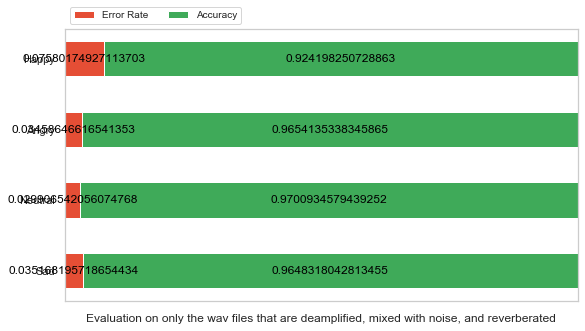

In [24]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the wav files that are deamplified, mixed with noise, and reverberated'
results = {
    'Happy': [dictionary_deamplified_noised_reverbed_h.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_h.get('accuracy')], \
    'Angry': [dictionary_deamplified_noised_reverbed_a.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_a.get('accuracy')], \
    'Neutral': [dictionary_deamplified_noised_reverbed_n.get('error_rate'), \
                dictionary_deamplified_noised_reverbed_n.get('accuracy')], \
    'Sad': [dictionary_deamplified_noised_reverbed_s.get('error_rate'), \
            dictionary_deamplified_noised_reverbed_s.get('accuracy')]
}

draw(results, category_names, graph_title)

## Evaluate all wav files

### evaluate the set of Happy validation

In [ ]:
dictionary_all_h = top_eval_all([emotionFolders[0]])

one_scores_all_h = dictionary_all_h.get('one_scores')
zero_scores_all_h = dictionary_all_h.get('zero_scores')
deamplified_dbs_all_h = dictionary_all_h.get('deamplified_dbs')
wetdrys_all_h = dictionary_all_h.get('wetdrys')
diffusions_all_h = dictionary_all_h.get('diffusions')
decayfactors_all_h = dictionary_all_h.get('decayfactors')

### evaluate the set of Angry validation

In [ ]:
dictionary_all_a = top_eval_all([emotionFolders[1]])

one_scores_all_a = dictionary_all_a.get('one_scores')
zero_scores_all_a = dictionary_all_a.get('zero_scores')
deamplified_dbs_all_a = dictionary_all_a.get('deamplified_dbs')
wetdrys_all_a = dictionary_all_a.get('wetdrys')
diffusions_all_a = dictionary_all_a.get('diffusions')
decayfactors_all_a = dictionary_all_a.get('decayfactors')

### evaluate the set of Neutral validation

In [ ]:
dictionary_all_n = top_eval_all([emotionFolders[2]])

one_scores_all_n = dictionary_all_n.get('one_scores')
zero_scores_all_n = dictionary_all_n.get('zero_scores')
deamplified_dbs_all_n = dictionary_all_n.get('deamplified_dbs')
wetdrys_all_n = dictionary_all_n.get('wetdrys')
diffusions_all_n = dictionary_all_n.get('diffusions')
decayfactors_all_n = dictionary_all_n.get('decayfactors')

### evaluate the set of Sad validation

In [ ]:
dictionary_all_s = top_eval_all([emotionFolders[3]])

one_scores_all_s = dictionary_all_s.get('one_scores')
zero_scores_all_s = dictionary_all_s.get('zero_scores')
deamplified_dbs_all_s = dictionary_all_s.get('deamplified_dbs')
wetdrys_all_s = dictionary_all_s.get('wetdrys')
diffusions_all_s = dictionary_all_s.get('diffusions')
decayfactors_all_s = dictionary_all_s.get('decayfactors')

### draw the plot (evaluation on all the wav files)

In [ ]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on all the wav files'
results = {
    'Happy': [dictionary_all_h.get('error_rate'), dictionary_all_h.get('accuracy')],
    'Angry': [dictionary_all_a.get('error_rate'), dictionary_all_a.get('accuracy')],
    'Neutral': [dictionary_all_n.get('error_rate'), dictionary_all_n.get('accuracy')],
    'Sad': [dictionary_all_s.get('error_rate'), dictionary_all_s.get('accuracy')]
}

draw(results, category_names, graph_title)